In [1]:
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import polars as pl
import re

np.random.seed(101)
shap.initjs()

##### Load sample sports and political data

In [2]:
sports_df = pl.read_csv('~/sports-language-in-politics/data/processed/sports_sample.csv')
politics_df = pl.read_csv('~/sports-language-in-politics/data/processed/politics_sample.csv')

##### Extract sports and political comments and clean. Generate boolean labels

Start with a sample

In [3]:
sample_size = 50000

sports_comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in sports_df['body'].to_list()]
political_comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in politics_df['body'].to_list()]

sports_comments = sports_comments[:sample_size]
political_comments = political_comments[:sample_size]

# labels
sports_y = np.ones(len(sports_comments), dtype=bool)
politics_y = np.zeros(len(political_comments), dtype=bool)

##### Concatenate, shuffle and split into train and test

In [4]:
sports_comments.extend(political_comments)
y = np.concatenate((sports_y, politics_y))

corpus_train, corpus_test, y_train, y_test = train_test_split(
    sports_comments, y, test_size=0.2, random_state=7
)

print('train data size : {}'.format(len(corpus_train)))
print('test data size : {}'.format(len(corpus_test)))

train data size : 80000
test data size : 20000


##### Fit a linear logistic regression model

In [5]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(
    corpus_train
).toarray()  # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(corpus_test).toarray()

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.83      0.78      0.80      9976
        True       0.79      0.84      0.82     10024

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



##### Results for different sample sizes

Do not run 

sample size : 20000

In [ ]:
              precision    recall  f1-score   support

       False       0.83      0.76      0.79      4014
        True       0.78      0.84      0.81      3986

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000

sample size : 50000 (being used)

In [ ]:
              precision    recall  f1-score   support

       False       0.83      0.78      0.80      9976
        True       0.79      0.84      0.82     10024

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

sample size : 100000

In [ ]:
             precision    recall  f1-score   support

       False       0.85      0.79      0.81     20021
        True       0.80      0.86      0.83     19979

    accuracy                           0.82     40000
   macro avg       0.82      0.82      0.82     40000
weighted avg       0.82      0.82      0.82     40000

##### Explain the linear model

In [6]:
explainer = shap.Explainer(
    model, X_train, feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test)

##### Summarize the effect of all the features

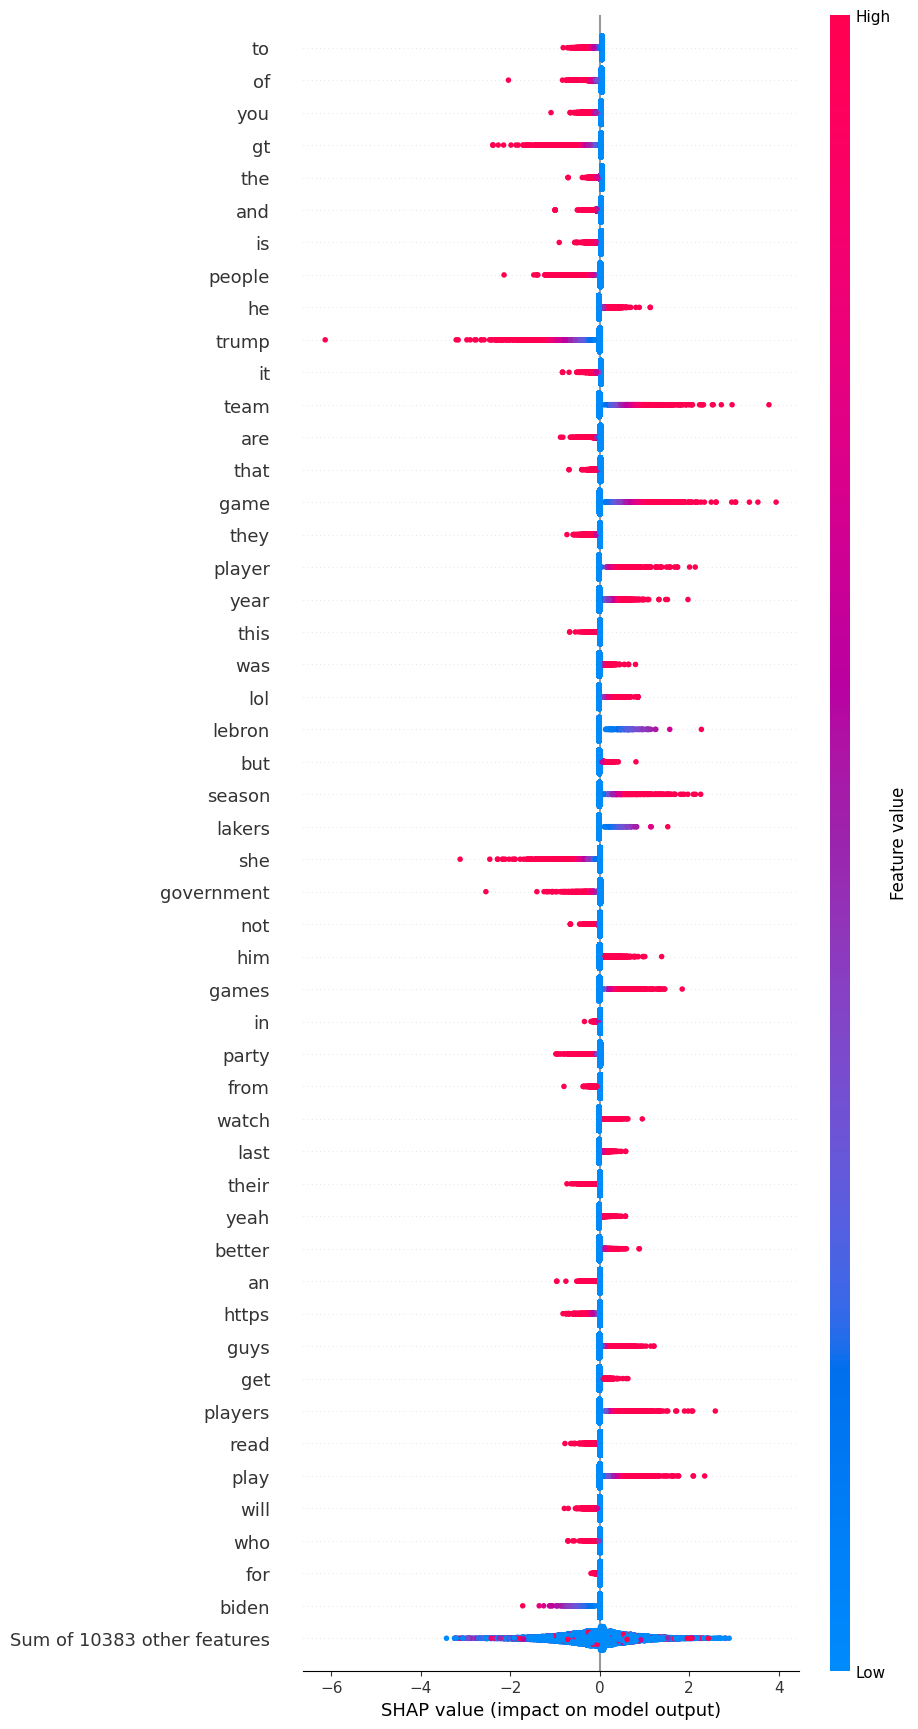

In [7]:
shap.plots.beeswarm(shap_values, max_display=50)

On the plot’s x-axis, dots represent the SHAP values of individual data instances, providing crucial information about feature influence. A wider spread or higher density of dots indicates more significant variability or a more substantial impact on the model’s predictions. This allows us to evaluate the significance of features in contributing to the model’s output.

In [133]:
mean_values = np.mean(shap_values.values, axis=0)
median_values = np.median(shap_values.values, axis=0)
min_values = np.min(shap_values.values, axis=0)
max_values = np.max(shap_values.values, axis=0)

In [134]:
feature_names = vectorizer.get_feature_names_out()

In [157]:
sports_words = []

for f in range(len(feature_names)):
    name = feature_names[f]
    if abs(min_values[f]) + 0.5 < abs(max_values[f]):
        sports_words.append(name)

In [158]:
len(sports_words)

154

In [163]:
political_words = []

for f in range(len(feature_names)):
    name = feature_names[f]
    if abs(min_values[f]) > abs(max_values[f]) + 0.5:
        political_words.append(name)

In [164]:
len(political_words)

152